In [5]:
# ========================================================================
# Cell [1]: Install Necessary Libraries (if not already installed)
# ========================================================================
%pip install fuzzywuzzy python-Levenshtein networkx pandas numpy torch torchtext



Note: you may need to restart the kernel to use updated packages.


In [6]:
# ========================================================================
# Cell [2]: Imports
# ========================================================================
import pandas as pd
import numpy as np
import networkx as nx

from fuzzywuzzy import fuzz
from itertools import product
from scipy.optimize import linear_sum_assignment

import torch
import torch.nn as nn
import torch.optim as optim


In [7]:
# ========================================================================
# Cell [3]: Example Data Setup
# ========================================================================
import pandas as pd

# Read data from the Excel file
cashBookDf = pd.read_excel("cashbook and bank_st.xlsx", sheet_name="CashBook")
bankStatementDf = pd.read_excel("cashbook and bank_st.xlsx", sheet_name="Bank Statement")

# Convert dates to a standard format (YYYY-MM-DD for consistency)
# Using errors='coerce' converts invalid date strings to NaT
cashBookDf["Transaction Date"] = pd.to_datetime(cashBookDf["Transaction Date"], format="%Y.%m.%d", errors='coerce')
bankStatementDf["Transaction Date"] = pd.to_datetime(bankStatementDf["Transaction Date"], format="%Y.%m.%d", errors='coerce')

# Optionally, drop rows with invalid dates (NaT)
cashBookDf = cashBookDf.dropna(subset=["Transaction Date"])
bankStatementDf = bankStatementDf.dropna(subset=["Transaction Date"])

print("Bank Statement Data:")
display(bankStatementDf)
print("\nCash Book Data:")
display(cashBookDf)
     

Bank Statement Data:


,Transaction Date,Description,Currency,Credit,Debit,Balance
0,2020-01-01,Software Consulting Service Payment,LKR,500000.00,NaN,5.500000e+06
1,2020-01-01,Office Rent Payment - January,LKR,NaN,150000.00,5.350000e+06
2,2020-01-02,Client Payment - Custom Software Development,LKR,300000.00,NaN,5.650000e+06
3,2020-01-02,Software Subscription - Yearly Renewal,LKR,NaN,200000.00,5.450000e+06
4,2020-01-03,Cloud Application Development,LKR,450000.00,NaN,5.900000e+06
...,...,...,...,...,...,...
3734,2025-02-28,Utility Payment - Internet,LKR,NaN,133920.49,1.658996e+08
3735,2025-02-28,Salary Payment - Employee,LKR,NaN,207880.37,1.656917e+08
3736,2025-02-28,Salary Payment - Employee,LKR,NaN,478652.95,1.652130e+08
3737,2025-02-28,Client Payment - Project B,LKR,165776.29,NaN,1.653788e+08



Cash Book Data:


,Transaction Date,Description,Currency,Credit,Debit,Balance
0,2020-01-01,Software Consulting Service Payment,LKR,500000.00,NaN,5.500000e+06
1,2020-01-01,Office Rent Payment - January,LKR,NaN,150000.00,5.350000e+06
2,2020-01-02,Client Payment - Custom Software Development,LKR,300000.00,NaN,5.650000e+06
3,2020-01-02,Software Subscription - Yearly Renewal,LKR,NaN,200000.00,5.450000e+06
4,2020-01-03,Cloud Application Development,LKR,450000.00,NaN,5.900000e+06
...,...,...,...,...,...,...
3710,2025-02-28,Utility Payment - Internet,LKR,NaN,133920.49,1.905573e+08
3711,2025-02-28,Salary Payment - Employee,LKR,NaN,207880.37,1.903494e+08
3712,2025-02-28,Salary Payment - Employee,LKR,NaN,478652.95,1.898708e+08
3713,2025-02-28,Client Payment - Project B,LKR,165776.29,NaN,1.900366e+08


In [8]:
# ========================================================================
# Cell [4]: Fuzzy Matching Function
# ========================================================================
def compute_fuzzy_score(desc_a, desc_b):
    """
    Returns a fuzzy match score between two description strings.
    You can choose different methods (token_set_ratio, partial_ratio, etc.).
    """
    return fuzz.token_set_ratio(desc_a.lower(), desc_b.lower())

# Example usage:
sample_score = compute_fuzzy_score("Software Consulting Service Payment", "Software Consulting Svc Payment")
print("Fuzzy Score Example:", sample_score)


Fuzzy Score Example: 94


In [9]:
import numpy as np
import pandas as pd
from fuzzywuzzy import fuzz
from scipy.optimize import linear_sum_assignment

# --------------------------------------------------------------------
# 1) Define Helper Functions
# --------------------------------------------------------------------
def compute_fuzzy_score(desc_a, desc_b):
    """
    Returns a fuzzy match score between two description strings, 0..100.
    """
    # Convert to string and lowercase to avoid errors with NaN or non-string data
    return fuzz.token_set_ratio(str(desc_a).lower(), str(desc_b).lower())

def compute_date_score(date_a, date_b, max_days=3):
    """
    Compute a date-based score in [0..1].
    Score is 1 if the two dates are the same day, and it decreases with day difference.
    You can tweak the logic/threshold as needed.
    """
    if pd.isnull(date_a) or pd.isnull(date_b):
        return 0.0
    diff_days = abs((date_a - date_b).days)
    if diff_days <= max_days:
        # Simple linear decay: 1.0 if diff_days=0, 0.0 if diff_days > max_days
        return 1.0 - (diff_days / max_days)
    else:
        return 0.0

def compute_amount_score(val_a, val_b, tolerance=1.0):
    """
    Compute a score in [0..1] based on how close val_a and val_b are.
    If the difference is within 'tolerance', score=1. Otherwise it decreases.
    Adjust logic as needed for your domain.
    """
    diff = abs(val_a - val_b)
    if diff <= tolerance:
        return 1.0
    else:
        # Example: degrade linearly beyond tolerance, with some arbitrary scale
        return max(0.0, 1.0 - (diff - tolerance) / (10 * tolerance))

# --------------------------------------------------------------------
# 2) Prepare DataFrames (local copies)
# --------------------------------------------------------------------
df_bank = bankStatementDf.copy()
df_cashbook = cashBookDf.copy()

bank_indices = list(df_bank.index)
cashbook_indices = list(df_cashbook.index)

# We'll build a similarity matrix to feed into the Hungarian algorithm
similarity_matrix = np.zeros((len(bank_indices), len(cashbook_indices)), dtype=float)

# --------------------------------------------------------------------
# 3) Compute Similarities for Each Bank/Cashbook Pair
# --------------------------------------------------------------------
for i, b_idx in enumerate(bank_indices):
    for j, c_idx in enumerate(cashbook_indices):
        
        # Extract relevant fields
        date_bank  = df_bank.loc[b_idx, "Transaction Date"]
        date_cash  = df_cashbook.loc[c_idx, "Transaction Date"]
        
        desc_bank  = df_bank.loc[b_idx, "Description"]
        desc_cash  = df_cashbook.loc[c_idx, "Description"]
        
        debit_bank  = df_bank.loc[b_idx, "Debit"]
        debit_cash  = df_cashbook.loc[c_idx, "Debit"]
        credit_bank = df_bank.loc[b_idx, "Credit"]
        credit_cash = df_cashbook.loc[c_idx, "Credit"]
        
        # 1) Date score (0..1)
        date_score = compute_date_score(date_bank, date_cash, max_days=3)
        
        # 2) Fuzzy description similarity (0..1)
        desc_similarity = compute_fuzzy_score(desc_bank, desc_cash) / 100.0
        
        # 3) Debit and credit scores
        debit_score  = compute_amount_score(debit_bank,  debit_cash,  tolerance=1.0)
        credit_score = compute_amount_score(credit_bank, credit_cash, tolerance=1.0)
        
        # Weighted combination of partial scores
        # Feel free to adjust weights as needed
        combined_score = (0.2 * date_score
                          + 0.4 * desc_similarity
                          + 0.2 * debit_score
                          + 0.2 * credit_score)
        
        similarity_matrix[i, j] = combined_score

# --------------------------------------------------------------------
# 4) Convert Similarity to Cost & Run Hungarian Algorithm
# --------------------------------------------------------------------
cost_matrix = 1.0 - similarity_matrix  # Hungarian solves min-cost, so cost = (1 - similarity)
row_ind, col_ind = linear_sum_assignment(cost_matrix)

# The pairs (row_ind[k], col_ind[k]) are your matches
matches = list(zip(row_ind, col_ind))

# Print results
print("Matches found (bank_index -> cashbook_index):")
for m in matches:
    b_i, c_j = m
    sim = similarity_matrix[b_i, c_j]
    print(f"Bank idx {b_i} -> Cashbook idx {c_j}, Similarity = {sim:.2f}")


Matches found (bank_index -> cashbook_index):
Bank idx 0 -> Cashbook idx 0, Similarity = 0.80
Bank idx 1 -> Cashbook idx 1, Similarity = 0.80
Bank idx 2 -> Cashbook idx 2, Similarity = 0.80
Bank idx 3 -> Cashbook idx 3, Similarity = 0.80
Bank idx 4 -> Cashbook idx 4, Similarity = 0.80
Bank idx 5 -> Cashbook idx 5, Similarity = 0.80
Bank idx 6 -> Cashbook idx 6, Similarity = 0.80
Bank idx 7 -> Cashbook idx 7, Similarity = 0.80
Bank idx 8 -> Cashbook idx 8, Similarity = 0.80
Bank idx 9 -> Cashbook idx 9, Similarity = 0.80
Bank idx 10 -> Cashbook idx 10, Similarity = 0.80
Bank idx 11 -> Cashbook idx 11, Similarity = 0.80
Bank idx 12 -> Cashbook idx 12, Similarity = 0.80
Bank idx 13 -> Cashbook idx 13, Similarity = 0.80
Bank idx 14 -> Cashbook idx 14, Similarity = 0.80
Bank idx 15 -> Cashbook idx 15, Similarity = 0.80
Bank idx 16 -> Cashbook idx 16, Similarity = 0.80
Bank idx 17 -> Cashbook idx 17, Similarity = 0.80
Bank idx 18 -> Cashbook idx 18, Similarity = 0.80
Bank idx 19 -> Cashbook 

In [10]:
# ========================================================================
# Cell [6]: Label Anomalies and Separate Right vs. Mismatched Pairs
# ========================================================================
threshold = 0.5

# Initialize sets for unmatched items and lists for matches
unmatched_bank = set(bank_indices)
unmatched_cashbook = set(cashbook_indices)
right_matches = []       # Matches that are "right" (sim_score >= threshold)
mismatched_matches = []  # Matches that are "mismatched" (sim_score < threshold)

# Process all pairs from the Hungarian matching
for (b_idx, c_idx) in matches:
    sim_score = similarity_matrix[b_idx, c_idx]
    if sim_score >= threshold:
        right_matches.append((b_idx, c_idx))
        unmatched_bank.discard(b_idx)
        unmatched_cashbook.discard(c_idx)
    else:
        mismatched_matches.append((b_idx, c_idx))
        # Note: We keep these indices in unmatched sets if needed

# For reporting, we can also consider any transactions that were never matched as mismatched.
# (They are already stored in unmatched_bank and unmatched_cashbook.)
print("Right (Correct) Matches (sim >= threshold):", right_matches)
print("Mismatched Matches (sim < threshold):", mismatched_matches)
print("Unmatched Bank Transactions (no good match found):", unmatched_bank)
print("Unmatched Cashbook Transactions (no good match found):", unmatched_cashbook)

# Now, label anomalies in the dataframes.
# We'll label a transaction as anomaly if:
# 1. It is part of a mismatched pair (sim_score < threshold)
# 2. Or it is completely unmatched (in the unmatched sets)

# Start with all transactions labeled as normal (0)
df_bank["anomaly_label"] = 0
df_cashbook["anomaly_label"] = 0

# Label mismatched pairs as anomalies
for (b_idx, c_idx) in mismatched_matches:
    df_bank.loc[b_idx, "anomaly_label"] = 1
    df_cashbook.loc[c_idx, "anomaly_label"] = 1

# Label any remaining unmatched transactions as anomalies
for b_idx in unmatched_bank:
    df_bank.loc[b_idx, "anomaly_label"] = 1
for c_idx in unmatched_cashbook:
    df_cashbook.loc[c_idx, "anomaly_label"] = 1

print("\nBank Data with Labels:")
display(df_bank)
print("\nCashbook Data with Labels:")
display(df_cashbook)


Right (Correct) Matches (sim >= threshold): [(np.int64(0), np.int64(0)), (np.int64(1), np.int64(1)), (np.int64(2), np.int64(2)), (np.int64(3), np.int64(3)), (np.int64(4), np.int64(4)), (np.int64(5), np.int64(5)), (np.int64(6), np.int64(6)), (np.int64(7), np.int64(7)), (np.int64(8), np.int64(8)), (np.int64(9), np.int64(9)), (np.int64(10), np.int64(10)), (np.int64(11), np.int64(11)), (np.int64(12), np.int64(12)), (np.int64(13), np.int64(13)), (np.int64(14), np.int64(14)), (np.int64(15), np.int64(15)), (np.int64(16), np.int64(16)), (np.int64(17), np.int64(17)), (np.int64(18), np.int64(18)), (np.int64(19), np.int64(19)), (np.int64(20), np.int64(20)), (np.int64(21), np.int64(21)), (np.int64(22), np.int64(22)), (np.int64(23), np.int64(23)), (np.int64(24), np.int64(24)), (np.int64(25), np.int64(25)), (np.int64(26), np.int64(26)), (np.int64(27), np.int64(27)), (np.int64(28), np.int64(28)), (np.int64(29), np.int64(29)), (np.int64(30), np.int64(30)), (np.int64(31), np.int64(31)), (np.int64(32), 

,Transaction Date,Description,Currency,Credit,Debit,Balance,anomaly_label
0,2020-01-01,Software Consulting Service Payment,LKR,500000.00,NaN,5.500000e+06,0.0
1,2020-01-01,Office Rent Payment - January,LKR,NaN,150000.00,5.350000e+06,0.0
2,2020-01-02,Client Payment - Custom Software Development,LKR,300000.00,NaN,5.650000e+06,0.0
3,2020-01-02,Software Subscription - Yearly Renewal,LKR,NaN,200000.00,5.450000e+06,0.0
4,2020-01-03,Cloud Application Development,LKR,450000.00,NaN,5.900000e+06,0.0
...,...,...,...,...,...,...,...
3735,2025-02-28,Salary Payment - Employee,LKR,NaN,207880.37,1.656917e+08,1.0
3736,2025-02-28,Salary Payment - Employee,LKR,NaN,478652.95,1.652130e+08,1.0
3737,2025-02-28,Client Payment - Project B,LKR,165776.29,NaN,1.653788e+08,1.0
3738,2025-02-28,Payment,LKR,321646.09,NaN,1.657005e+08,1.0



Cashbook Data with Labels:


,Transaction Date,Description,Currency,Credit,Debit,Balance,anomaly_label
0,2020-01-01,Software Consulting Service Payment,LKR,500000.00,NaN,5.500000e+06,0
1,2020-01-01,Office Rent Payment - January,LKR,NaN,150000.00,5.350000e+06,0
2,2020-01-02,Client Payment - Custom Software Development,LKR,300000.00,NaN,5.650000e+06,0
3,2020-01-02,Software Subscription - Yearly Renewal,LKR,NaN,200000.00,5.450000e+06,0
4,2020-01-03,Cloud Application Development,LKR,450000.00,NaN,5.900000e+06,0
...,...,...,...,...,...,...,...
3710,2025-02-28,Utility Payment - Internet,LKR,NaN,133920.49,1.905573e+08,0
3711,2025-02-28,Salary Payment - Employee,LKR,NaN,207880.37,1.903494e+08,1
3712,2025-02-28,Salary Payment - Employee,LKR,NaN,478652.95,1.898708e+08,1
3713,2025-02-28,Client Payment - Project B,LKR,165776.29,NaN,1.900366e+08,1


In [11]:
# ========================================================================
# Cell [7]: Prepare Time-Series Data for TCN
# ========================================================================
import numpy as np
import pandas as pd

# Combine bank and cashbook transactions for a single timeline
df_combined = pd.concat([
    df_bank.assign(Source="Bank"),
    df_cashbook.assign(Source="Cashbook")
]).sort_values("Transaction Date")

df_combined.reset_index(drop=True, inplace=True)

# Extract features (Credit, Debit) and anomaly labels
features = df_combined[["Credit", "Debit"]].values
labels = df_combined["anomaly_label"].values

# Create overlapping windows for TCN training.
# For each window of length 'seq_len', we predict the label of the last transaction.
seq_len = 4
X_seq = []
y_seq = []
for i in range(len(features) - seq_len):
    X_seq.append(features[i : i + seq_len])
    y_seq.append(labels[i + seq_len - 1])

X_seq = np.array(X_seq, dtype=np.float32)
y_seq = np.array(y_seq, dtype=np.float32)

print("Shape of input sequence:", X_seq.shape)
print("Shape of labels:", y_seq.shape)


Shape of input sequence: (7419, 4, 2)
Shape of labels: (7419,)


In [12]:
# ========================================================================
# Cell [8]: Define a Simple TCN Model in PyTorch (Corrected)
# ========================================================================
import torch
import torch.nn as nn

class TCNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=2, dilation=1):
        super(TCNBlock, self).__init__()
        self.conv = nn.Conv1d(
            in_channels, 
            out_channels, 
            kernel_size,
            padding=(kernel_size - 1) * dilation, 
            dilation=dilation
        )
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        self.conv_skip = nn.Conv1d(in_channels, out_channels, kernel_size=1)
        
    def forward(self, x):
        # x shape: (batch, channels, sequence_length)
        out = self.conv(x)
        out = self.relu(out)
        out = self.dropout(out)
        
        # Skip connection via 1x1 convolution
        skip = self.conv_skip(x)
        
        # Crop extra time steps from 'out' to match 'skip', if needed
        if out.size(2) != skip.size(2):
            out = out[:, :, :skip.size(2)]
        
        return out + skip

class SimpleTCN(nn.Module):
    def __init__(self, input_dim, num_channels=16, num_layers=2, kernel_size=2):
        super(SimpleTCN, self).__init__()
        
        layers = []
        in_channels = input_dim
        dilation = 1
        
        for _ in range(num_layers):
            layers.append(TCNBlock(in_channels, num_channels, kernel_size, dilation=dilation))
            in_channels = num_channels
            dilation *= 2
        
        self.network = nn.Sequential(*layers)
        # Final linear layer to produce 1 output (raw logits for binary classification)
        self.fc = nn.Linear(num_channels, 1)
        # Note: We intentionally do not apply a final sigmoid here.
        
    def forward(self, x):
        # Input x: (batch, seq_len, input_dim)
        # Permute to (batch, input_dim, seq_len) as required by Conv1d
        x = x.permute(0, 2, 1)
        out = self.network(x)    # shape: (batch, num_channels, seq_len_adjusted)
        out = out[:, :, -1]      # take the last time step output: (batch, num_channels)
        out = self.fc(out)       # raw logits: (batch, 1)
        return out              # no final activation!


After cleaning, check X_seq_clean for NaNs/inf: False False
Check y_seq for NaNs/inf: False False
y_seq distribution (counts of 0/1): (array([0., 1.], dtype=float32), array([7344,   75]))
Found two classes in y_train: [0. 1.], counts: [5139   54]
Using pos_weight: 95.16666412353516
Epoch [1/10], Train Loss: 1.3975, Test Loss: 1.3488
Epoch [2/10], Train Loss: 1.3939, Test Loss: 1.3434
Epoch [3/10], Train Loss: 1.3951, Test Loss: 1.3384
Epoch [4/10], Train Loss: 1.3923, Test Loss: 1.3335
Epoch [5/10], Train Loss: 1.3827, Test Loss: 1.3289
Epoch [6/10], Train Loss: 1.3810, Test Loss: 1.3246
Epoch [7/10], Train Loss: 1.3839, Test Loss: 1.3205
Epoch [8/10], Train Loss: 1.3814, Test Loss: 1.3167
Epoch [9/10], Train Loss: 1.3800, Test Loss: 1.3133
Epoch [10/10], Train Loss: 1.3747, Test Loss: 1.3100
Confusion Matrix:
[[  60 2145]
 [   0   21]]


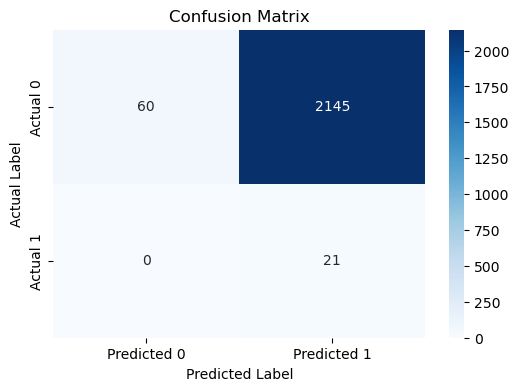

In [13]:
# ========================================================================
# Cell [9]: Train the TCN (Corrected using BCEWithLogitsLoss) and Confusion Matrix
# ========================================================================
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

# ---------------------------------------------------------
# 1) Data Cleaning & Scaling
# ---------------------------------------------------------
# Replace any NaNs in X_seq with 0.0
X_seq_clean = np.nan_to_num(X_seq, nan=0.0)

print("After cleaning, check X_seq_clean for NaNs/inf:",
      np.isnan(X_seq_clean).any(), np.isinf(X_seq_clean).any())
print("Check y_seq for NaNs/inf:",
      np.isnan(y_seq).any(), np.isinf(y_seq).any())
print("y_seq distribution (counts of 0/1):", np.unique(y_seq, return_counts=True))

# Reshape to 2D, scale, and then reshape back to 3D
num_samples, seq_len, num_features = X_seq_clean.shape
X_seq_reshaped = X_seq_clean.reshape(-1, num_features)
scaler = StandardScaler()
X_seq_scaled = scaler.fit_transform(X_seq_reshaped)
X_seq_scaled = X_seq_scaled.reshape(num_samples, seq_len, num_features)

# ---------------------------------------------------------
# 2) Create Train/Test Splits with Scaled Data
# ---------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X_seq_scaled, y_seq, test_size=0.3, random_state=42
)

X_train_t = torch.from_numpy(X_train).float()
y_train_t = torch.from_numpy(y_train).unsqueeze(1).float()  # shape: (batch, 1)
X_test_t  = torch.from_numpy(X_test).float()
y_test_t  = torch.from_numpy(y_test).unsqueeze(1).float()

# ---------------------------------------------------------
# 3) Initialize Model & Training Setup
# ---------------------------------------------------------
input_dim = X_train_t.shape[2]
# Use the SimpleTCN model defined in Cell [8]
model = SimpleTCN(input_dim=input_dim, num_channels=16, num_layers=2, kernel_size=2)

# Safely compute pos_weight for BCEWithLogitsLoss to handle class imbalance
unique, counts = np.unique(y_train, return_counts=True)
if len(unique) == 2:
    pos_weight_val = counts[0] / counts[1]
    print(f"Found two classes in y_train: {unique}, counts: {counts}")
else:
    # Only one class is present (all 0 or all 1)
    pos_weight_val = 1.0
    print(f"Found single class in y_train: {unique}, counts: {counts}")

pos_weight = torch.tensor([pos_weight_val], dtype=torch.float32)
print("Using pos_weight:", pos_weight.item())

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)  # works with raw logits
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 10

# ---------------------------------------------------------
# 4) Training Loop with Gradient Clipping
# ---------------------------------------------------------
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    
    outputs = model(X_train_t)  # raw logits output
    loss = criterion(outputs, y_train_t)
    loss.backward()
    
    # Clip gradients to mitigate exploding gradients
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    
    # Evaluate on test set
    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test_t)
        test_loss = criterion(test_outputs, y_test_t)
    
    print(f"Epoch [{epoch+1}/{epochs}], "
          f"Train Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}")

# ---------------------------------------------------------
# 5) Compute and Display Confusion Matrix on Test Set
# ---------------------------------------------------------
model.eval()
with torch.no_grad():
    test_outputs = model(X_test_t)           # raw logits
    test_probs = torch.sigmoid(test_outputs) # convert logits to probabilities
    predicted_labels = (test_probs >= 0.5).float()  # binary predictions

# Convert tensors to numpy arrays
y_true = y_test_t.cpu().numpy().flatten()
y_pred = predicted_labels.cpu().numpy().flatten()

cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Confusion Matrix')
plt.show()


In [14]:
# ========================================================================
# Cell [10]: Inference / Anomaly Detection
# ========================================================================
# After training, you can use the TCN to predict whether a new sequence is anomalous.
# For example, let's predict on the test set:

model.eval()
with torch.no_grad():
    predictions = model(X_test_t).squeeze().numpy()  # shape: (num_test_samples,)
    
# Convert probabilities to binary predictions (0 or 1)
threshold_prob = 0.5
pred_labels = (predictions >= threshold_prob).astype(int)

# Compare with true labels
true_labels = y_test_t.squeeze().numpy()

# Quick metrics
accuracy = np.mean(pred_labels == true_labels)
print(f"Test Accuracy: {accuracy:.2f}")

# In a real scenario, you'd use more appropriate metrics for anomaly detection
# (precision, recall, F1, confusion matrix, etc.)


Test Accuracy: 0.99
